<a href="https://colab.research.google.com/github/promitdutta-biz/data_analyst_projects/blob/main/Hotel_Bookings_XGBoost_Classification_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
import xgboost as xgboost
from xgboost import plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, precision_recall_curve, f1_score, auc
from sklearn.metrics import classification_report # for model evaluation metrics
from xgboost import XGBClassifier # for extreme gradient boosting model
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score, auc

In [90]:
!pip install shap
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 9.1 MB/s eta 0:00:00


In [20]:
path= "/content/drive/MyDrive/data_science_proj/hotel_bookings.csv"
df = pd.read_csv(path)

In [21]:
#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [ ]:
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [22]:
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])
df['reservation_status_month']=pd.to_datetime(df['reservation_status_date']).dt.month

In [23]:
data1 = {
  "arrival_date_month": ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"],
  "arrival_date_month_num": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
}
df_1 = pd.DataFrame(data1)
df = pd.merge(df, df_1, on='arrival_date_month')

In [24]:
df.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [25]:
df.shape

(119390, 34)

In [26]:
df['children'].value_counts(normalize=True)*100

0.0     92.804851
1.0      4.071667
2.0      3.058985
3.0      0.063659
10.0     0.000838
Name: children, dtype: float64

In [27]:
df['children'].fillna(0, inplace = True) # replacing wiht most frequent observation
df['country'].fillna('others', axis=0, inplace=True) # tagging with 'others'
df.drop(['agent','company'], axis=1, inplace=True)

In [28]:
df = df[df['adr']!=0] # we are interested in only those observations where the adr has some values, cancellatiions will affect

In [29]:
df['booking_amt']=((df['stays_in_week_nights']+df['stays_in_weekend_nights']))*df['adr']
df['booking_amt_per_person']= df['booking_amt'].astype('float')/((df['adults'].astype('float')+df['children'].astype('float')))

- RO: Room only / SC : means self-catering (no meals are included).

- BB: Bed & Breakfast

- HB: Half Board (Breakfast and Dinner normally)

- FB: Full Board (Beakfast, Lunch and Dinner)

- AI: All Inclusive (all services of full board plus any others specified in each case)

Drinks are not included in the prices unless expressly indicated by the hotel.

In [30]:
df['meal'].value_counts(normalize=True)*100

BB           77.334775
HB           12.145004
SC            8.891179
Undefined     0.963119
FB            0.665923
Name: meal, dtype: float64

City Hotel      66.525875
Resort Hotel    33.474125
Name: hotel, dtype: float64


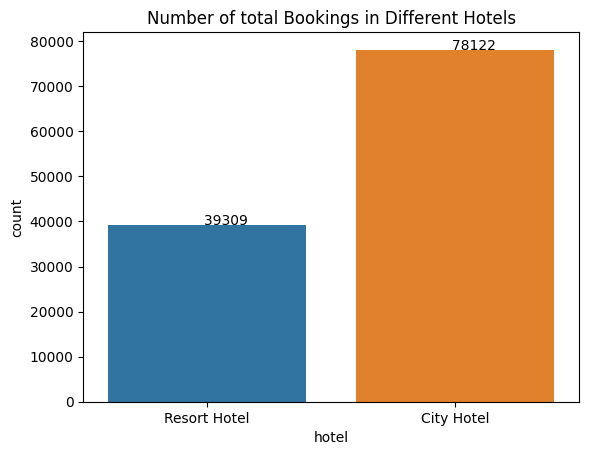

In [31]:
print(df['hotel'].value_counts(normalize=True)*100)
ax1 = sns.countplot(x='hotel', data =df)
for p in ax1.patches:
        ax1.annotate('{0:10d}'.format(int(p.get_height())), (p.get_x()+0.3, p.get_height()+60))
plt.title('Number of total Bookings in Different Hotels')
plt.show()

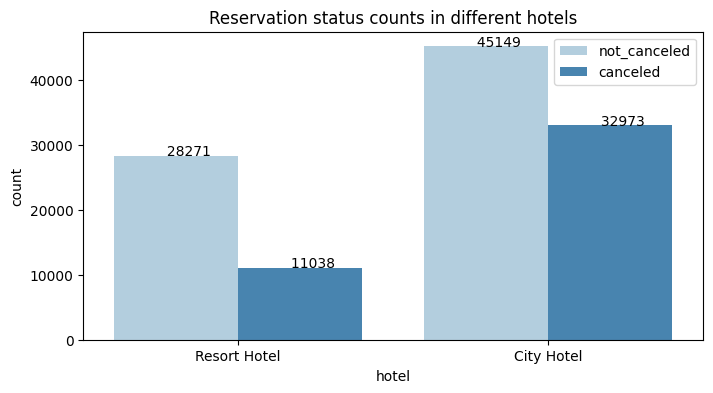

In [32]:
plt.figure(figsize=(8,4))
ax1=sns.countplot(x='hotel',hue='is_canceled',data=df, palette='Blues')
legend_labels,_ = ax1.get_legend_handles_labels()
ax1.legend(['not_canceled','canceled'])
plt.title('Reservation status counts in different hotels')
for p in ax1.patches:
        ax1.annotate('{0:10d}'.format(int(p.get_height())), (p.get_x()+0.1, p.get_height()+60))
plt.show()

In [33]:
df['is_canceled'].value_counts(normalize=True)*100

0    62.521821
1    37.478179
Name: is_canceled, dtype: float64

In [34]:
df[df['hotel']=='City Hotel']['is_canceled'].value_counts(normalize=True)*100

0    57.792939
1    42.207061
Name: is_canceled, dtype: float64

In [35]:
df[df['hotel']=='Resort Hotel']['is_canceled'].value_counts(normalize=True)*100

0    71.919917
1    28.080083
Name: is_canceled, dtype: float64

The cancellation rate is higher in City Hotel 41.72% as compared to 27.76% in Resort Hotel.

In [36]:
df['market_segment'].value_counts(normalize=True)*100

Online TA        47.781250
Offline TA/TO    20.341307
Groups           16.655738
Direct           10.530439
Corporate         4.439203
Aviation          0.196711
Complementary     0.053649
Undefined         0.001703
Name: market_segment, dtype: float64

In [37]:
df[df['hotel']=='City Hotel']['market_segment'].value_counts(normalize=True)*100

Online TA        49.377896
Offline TA/TO    21.134892
Groups           17.704360
Direct            7.657254
Corporate         3.783825
Aviation          0.295691
Complementary     0.043522
Undefined         0.002560
Name: market_segment, dtype: float64

In [38]:
df[df['hotel']=='Resort Hotel']['market_segment'].value_counts(normalize=True)*100

Online TA        44.608105
Offline TA/TO    18.764151
Direct           16.240556
Groups           14.571727
Corporate         5.741688
Complementary     0.073774
Name: market_segment, dtype: float64

In [39]:
df_mar_seg = df[['hotel','market_segment','is_canceled']] #.groupby(by=['hotel','market_segment','is_canceled'])['is_canceled'].count().to_frame()
df_mar_seg['can_status_1'] = np.where(df_mar_seg['is_canceled'] ==1, 1, 0)
df_mar_seg['can_status_0'] = np.where(df_mar_seg['is_canceled'] ==0, 1, 0)
df_mar_seg.head()

<ipython-input-39-0425094f1308>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-39-0425094f1308>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,hotel,market_segment,is_canceled,can_status_1,can_status_0
2,Resort Hotel,Direct,0,0,1
3,Resort Hotel,Corporate,0,0,1
4,Resort Hotel,Online TA,0,0,1
5,Resort Hotel,Online TA,0,0,1
6,Resort Hotel,Direct,0,0,1


In [40]:
import plotly.express as px
fig = px.sunburst(data_frame = df_mar_seg,
                  path=['hotel','market_segment'],
                  values='can_status_1',
                  title="Cancelation pattern for different hotels and market segments")
fig.show()

In [41]:
import plotly.express as px
fig = px.sunburst(data_frame = df_mar_seg,
                  path=['hotel','market_segment'],
                  values='can_status_0',
                  title="Successful booking pattern for different hotels and market segments")

fig.show()

Resort hotel has higher share of successful bookings.

The contribution for the travel agents are in the order Online TA, Offline TA/TO, Direct, Groups, Corporate in both the hotels.

In [42]:
df['is_repeated_guest'].value_counts(normalize=True)*100

0    97.21198
1     2.78802
Name: is_repeated_guest, dtype: float64

In [43]:
df['reserved_room_type'].value_counts(normalize=True)*100

A    72.020165
D    16.183972
E     5.469595
F     2.404816
G     1.708237
B     0.923947
C     0.777478
H     0.506681
L     0.005109
Name: reserved_room_type, dtype: float64

In [44]:
df['booking_changes'].value_counts(normalize=True)*100

0     85.072936
1     10.494673
2      3.160154
3      0.766408
4      0.304008
5      0.092820
6      0.049391
7      0.022992
8      0.011070
9      0.005961
10     0.005109
13     0.003406
14     0.002555
15     0.002555
12     0.001703
16     0.001703
11     0.000852
17     0.000852
18     0.000852
Name: booking_changes, dtype: float64

In [45]:
df['deposit_type'].value_counts(normalize=True)*100

No Deposit    87.440284
Non Refund    12.421763
Refundable     0.137953
Name: deposit_type, dtype: float64

In [46]:
(df[['is_canceled','deposit_type','hotel']].groupby(by=['deposit_type','hotel'])['is_canceled'].value_counts(normalize=True)*100)

deposit_type  hotel         is_canceled
No Deposit    City Hotel    0              69.164853
                            1              30.835147
              Resort Hotel  0              74.989319
                            1              25.010681
Non Refund    City Hotel    1              99.813491
                            0               0.186509
              Resort Hotel  1              95.986038
                            0               4.013962
Refundable    City Hotel    1              70.000000
                            0              30.000000
              Resort Hotel  0              84.507042
                            1              15.492958
Name: is_canceled, dtype: float64

**Signifiicant observations on deposit type**

In Non Refund deposit type almost all bookings get cancelleld. rate of cancellation are 99.81% and 95.95% in City and Resort hotel respectively. In refundablel deposit type the rate of cancelation is low in resort hotel (~15.49%)

In [47]:
df[['customer_type','hotel', 'is_canceled']].groupby(by=['customer_type','hotel'])['is_canceled'].value_counts(normalize=True)*100

customer_type    hotel         is_canceled
Contract         City Hotel    0              51.748252
                               1              48.251748
                 Resort Hotel  0              91.099773
                               1               8.900227
Group            City Hotel    0              89.824561
                               1              10.175439
                 Resort Hotel  0              94.980695
                               1               5.019305
Transient        City Hotel    0              53.856147
                               1              46.143853
                 Resort Hotel  0              68.437911
                               1              31.562089
Transient-Party  City Hotel    0              71.581109
                               1              28.418891
                 Resort Hotel  0              80.241248
                               1              19.758752
Name: is_canceled, dtype: float64

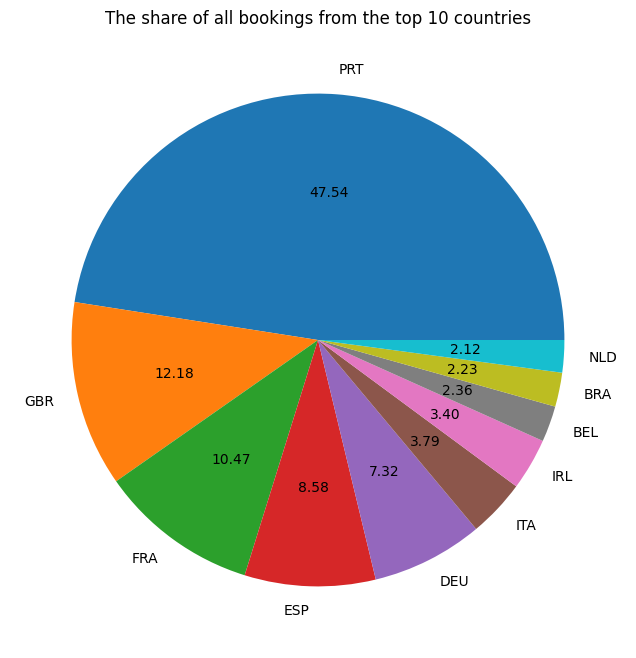

In [48]:
top_10_country=df['country'].value_counts()[0:10]
plt.figure(figsize=(8,8))
plt.pie(top_10_country, autopct='%.2f', labels=top_10_country.index)
plt.title('The share of all bookings from the top 10 countries')
plt.show()

0    62.521821
1    37.478179
Name: is_canceled, dtype: float64


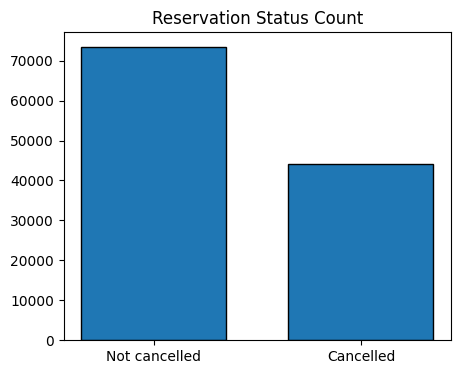

In [49]:
cancelled_perc=df['is_canceled'].value_counts(normalize=True)*100
print(cancelled_perc)

plt.figure(figsize=(5,4))
plt.title('Reservation Status Count')
plt.bar(['Not cancelled', 'Cancelled'],df['is_canceled'].value_counts(), edgecolor='k', width=0.7)
plt.show()

In [50]:
#df['reservation_status_date']= pd.to_datetime(df['reservation_status_date'])
resort_hotel=df[df['hotel']=='Resort Hotel']
city_hotel=df[df['hotel']=='City Hotel']

resort_hotel= resort_hotel.groupby('reservation_status_date')[['adr']].mean()
city_hotel= city_hotel.groupby('reservation_status_date')[['adr']].mean()

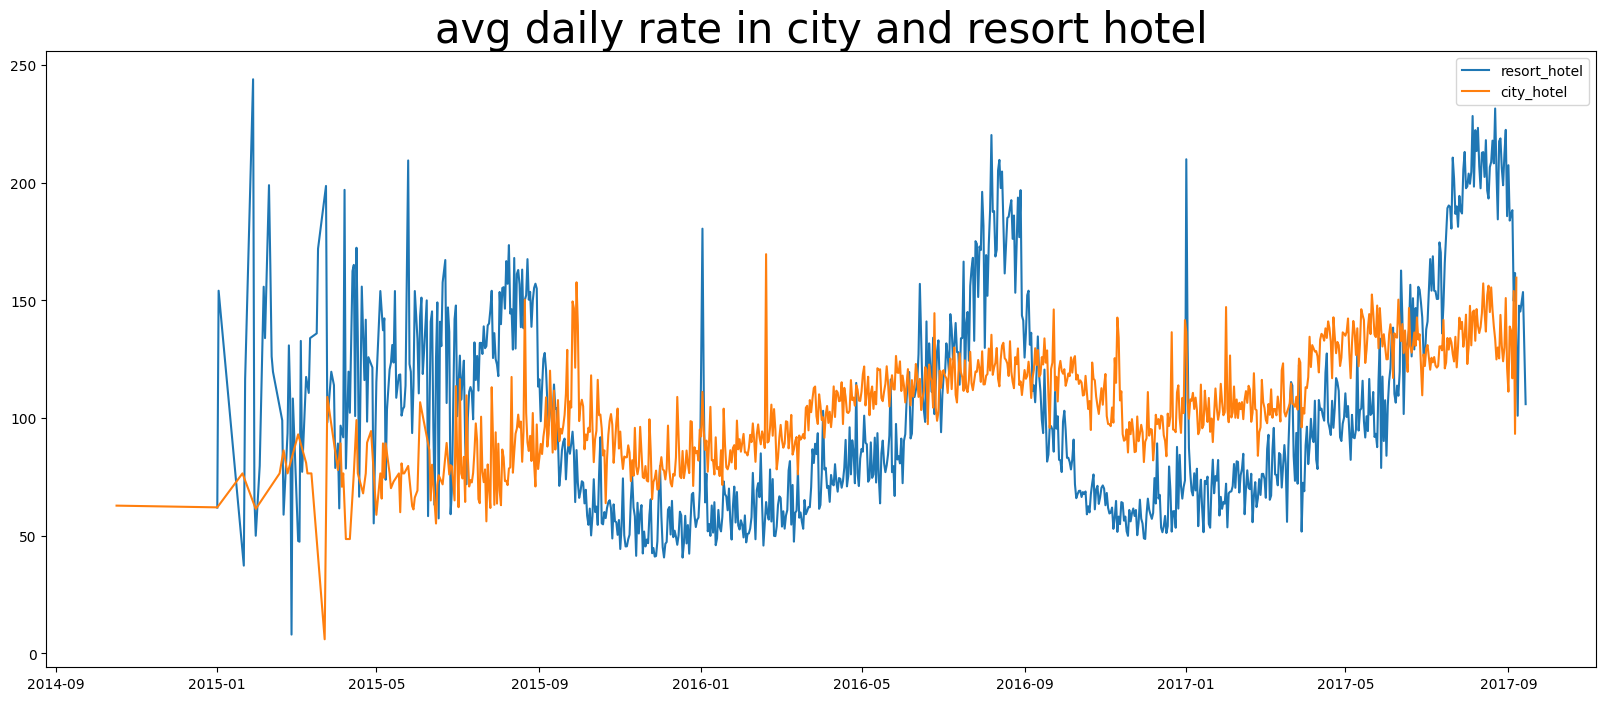

In [51]:
plt.figure(figsize=(20,8))
plt.title('avg daily rate in city and resort hotel', fontsize=30)
plt.plot(resort_hotel.index, resort_hotel['adr'], label='resort_hotel')
plt.plot(city_hotel.index, city_hotel['adr'], label='city_hotel')
plt.legend()
plt.show()

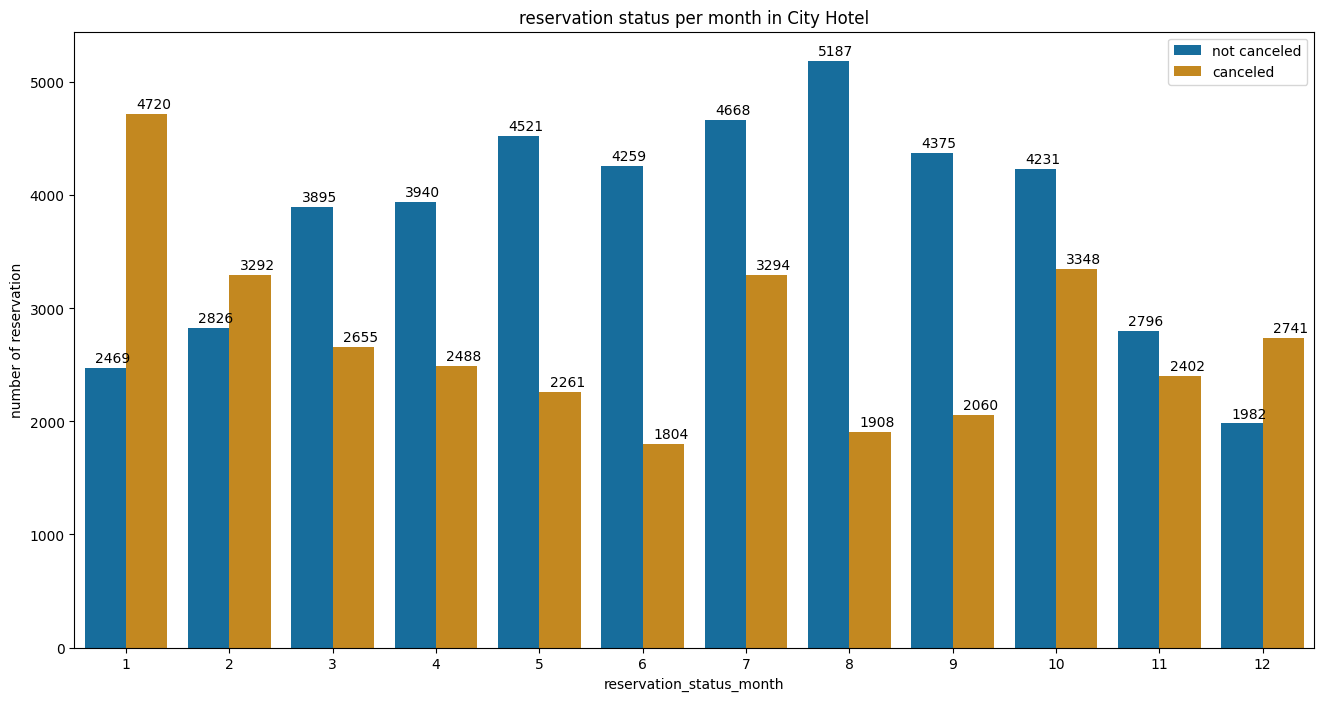

In [52]:
plt.figure(figsize=(16,8))
ax1 = sns.countplot(x='reservation_status_month', hue='is_canceled', data= df[df['hotel']=='City Hotel'], palette= 'colorblind')
plt.title('reservation status per month in City Hotel')
plt.xlabel('reservation_status_month')
plt.ylabel('number of reservation')
plt.legend(['not canceled','canceled'])
for p in ax1.patches:
        ax1.annotate('{}'.format(int(p.get_height())), (p.get_x()+0.1, p.get_height()+50))
plt.show()

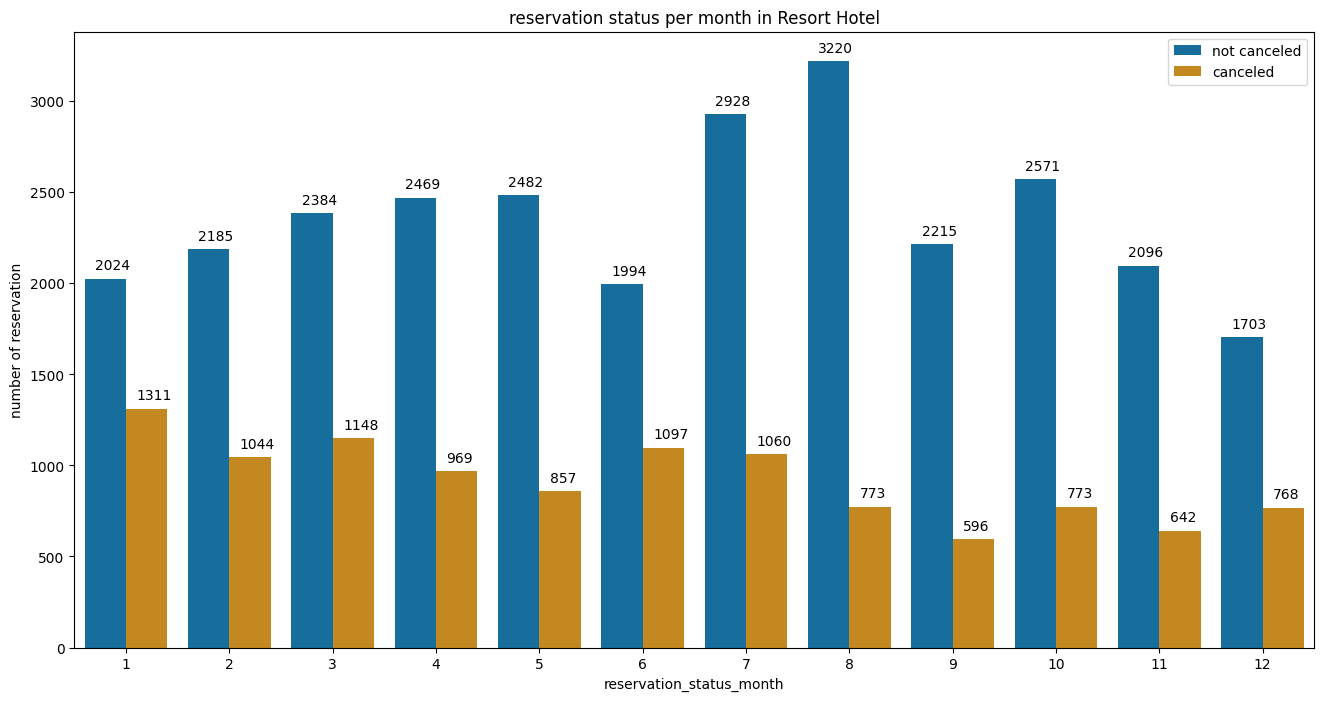

In [53]:
plt.figure(figsize=(16,8))
ax1 = sns.countplot(x='reservation_status_month', hue='is_canceled', data= df[df['hotel']=='Resort Hotel'], palette= 'colorblind')
plt.title('reservation status per month in Resort Hotel')
plt.xlabel('reservation_status_month')
plt.ylabel('number of reservation')
plt.legend(['not canceled','canceled'])
for p in ax1.patches:
        ax1.annotate('{}'.format(int(p.get_height())), (p.get_x()+0.1, p.get_height()+50))
plt.show()

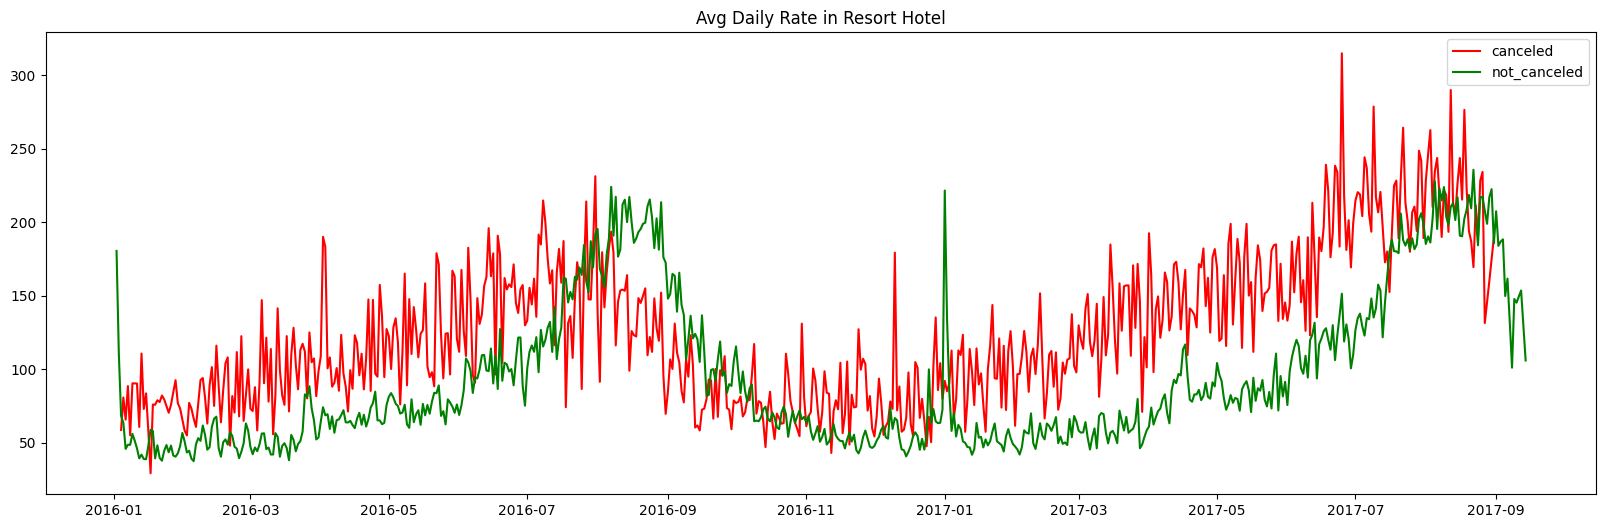

In [54]:
df_rh=df[df['hotel']=='Resort Hotel']
not_canceled_data= df_rh[df_rh['is_canceled']==0]
canceled_data=df_rh[df_rh['is_canceled']==1]

canceled_df_adr= canceled_data.groupby('reservation_status_date')[['adr']].mean()
canceled_df_adr.reset_index(inplace=True)
canceled_df_adr.sort_values('reservation_status_date',inplace=True)

not_canceled_df_adr= not_canceled_data.groupby('reservation_status_date')[['adr']].mean()
not_canceled_df_adr.reset_index(inplace=True)
not_canceled_df_adr.sort_values('reservation_status_date',inplace=True)

canceled_df_adr=canceled_df_adr[(canceled_df_adr['reservation_status_date'])>'2016']
not_canceled_df_adr=not_canceled_df_adr[(not_canceled_df_adr['reservation_status_date'])>'2016']

plt.figure(figsize=(20,6))
plt.title('Avg Daily Rate in Resort Hotel')
plt.plot(canceled_df_adr['reservation_status_date'], canceled_df_adr['adr'], label='canceled', color='red')
plt.plot(not_canceled_df_adr['reservation_status_date'], not_canceled_df_adr['adr'], label='not_canceled', color='green')

plt.legend()
plt.show()

in the months Jan-July the adr plays a huge role in cancellation. Higher the price, more is the chance of cancellatiom.

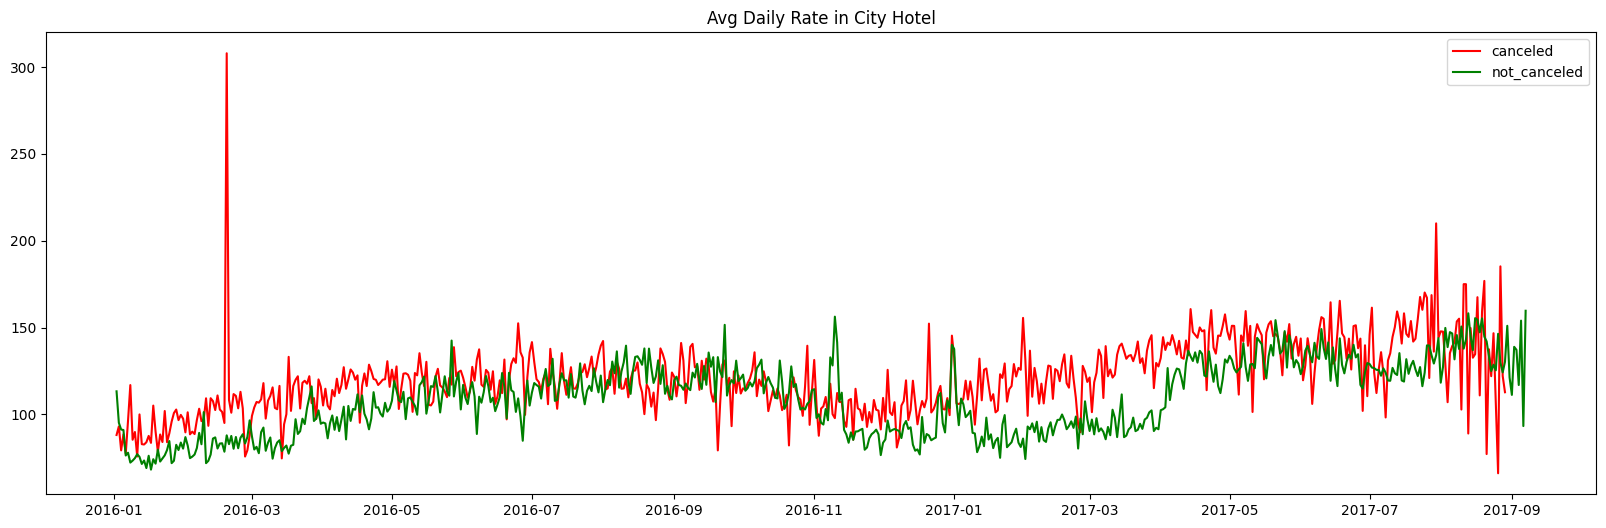

In [55]:
df_ch=df[df['hotel']=='City Hotel']
not_canceled_data= df_ch[df_ch['is_canceled']==0]
canceled_data=df_ch[df_ch['is_canceled']==1]

canceled_df_adr= canceled_data.groupby('reservation_status_date')[['adr']].mean()
canceled_df_adr.reset_index(inplace=True)
canceled_df_adr.sort_values('reservation_status_date',inplace=True)

not_canceled_df_adr= not_canceled_data.groupby('reservation_status_date')[['adr']].mean()
not_canceled_df_adr.reset_index(inplace=True)
not_canceled_df_adr.sort_values('reservation_status_date',inplace=True)

canceled_df_adr=canceled_df_adr[(canceled_df_adr['reservation_status_date'])>'2016']
not_canceled_df_adr=not_canceled_df_adr[(not_canceled_df_adr['reservation_status_date'])>'2016']

plt.figure(figsize=(20,6))
plt.title('Avg Daily Rate in City Hotel')
plt.plot(canceled_df_adr['reservation_status_date'], canceled_df_adr['adr'], label='canceled', color='red')
plt.plot(not_canceled_df_adr['reservation_status_date'], not_canceled_df_adr['adr'], label='not_canceled', color='green')

plt.legend()
plt.show()

the price as a factor influencing cancellation is very much true in resort hotel but not that much true in city hotel. The fluctuation of price is also higher in Resort Hotel where as in city hotel it is tight range bound.

In [56]:
df[['is_canceled','reservation_status']].groupby(by='is_canceled')['reservation_status'].value_counts()

is_canceled  reservation_status
0            Check-Out             73420
1            Canceled              42830
             No-Show                1181
Name: reservation_status, dtype: int64

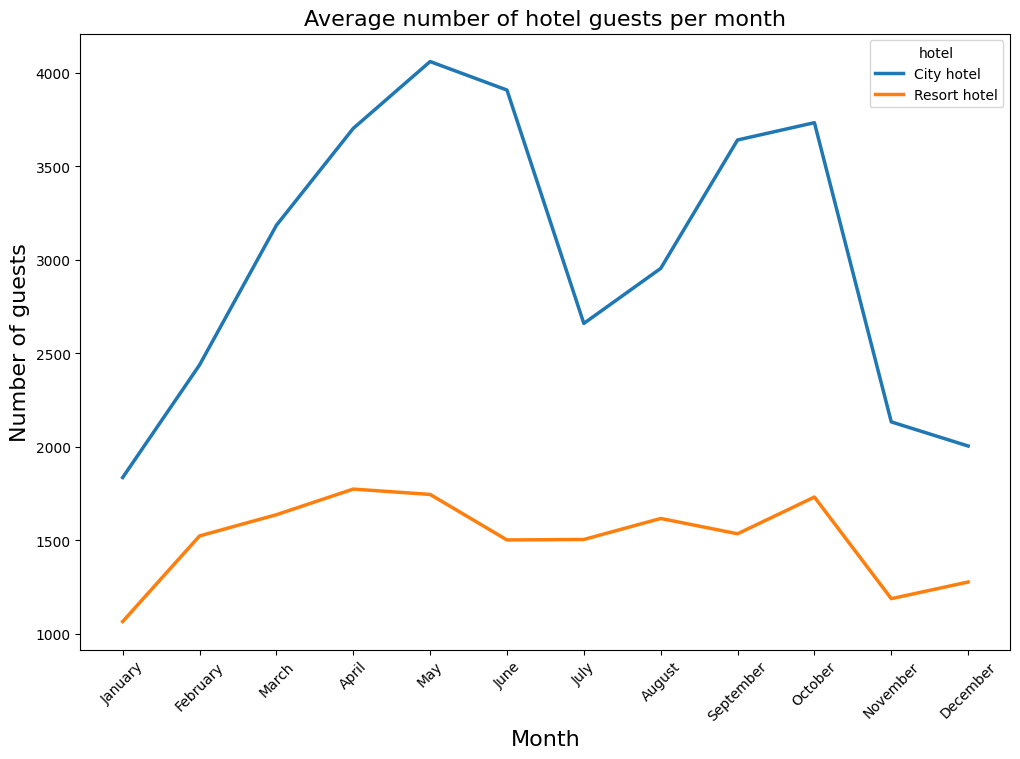

In [57]:
rh=df[df['hotel']=='Resort Hotel']
ch=df[df['hotel']=='City Hotel']

# Create a DateFrame with the relevant data:
resort_guests_monthly = rh.groupby("arrival_date_month")["hotel"].count()
city_guests_monthly = ch.groupby("arrival_date_month")["hotel"].count()

resort_guest_data = pd.DataFrame({"month": list(resort_guests_monthly.index),
                    "hotel": "Resort hotel",
                    "guests": list(resort_guests_monthly.values)})

city_guest_data = pd.DataFrame({"month": list(city_guests_monthly.index),
                    "hotel": "City hotel",
                    "guests": list(city_guests_monthly.values)})
full_guest_data = pd.concat([resort_guest_data,city_guest_data], ignore_index=True)

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]
full_guest_data["month"] = pd.Categorical(full_guest_data["month"], categories=ordered_months, ordered=True)

# Dataset contains July and August date from 3 years, the other month from 2 years. Normalize data:
full_guest_data.loc[(full_guest_data["month"] == "July") | (full_guest_data["month"] == "August"),
                    "guests"] /= 3
full_guest_data.loc[~((full_guest_data["month"] == "July") | (full_guest_data["month"] == "August")),
                    "guests"] /= 2

#show figure:
plt.figure(figsize=(12, 8))
sns.lineplot(x = "month", y="guests", hue="hotel", data=full_guest_data,
             hue_order = ["City hotel", "Resort hotel"], size="hotel", sizes=(2.5, 2.5))
plt.title("Average number of hotel guests per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Number of guests", fontsize=16)
plt.show()

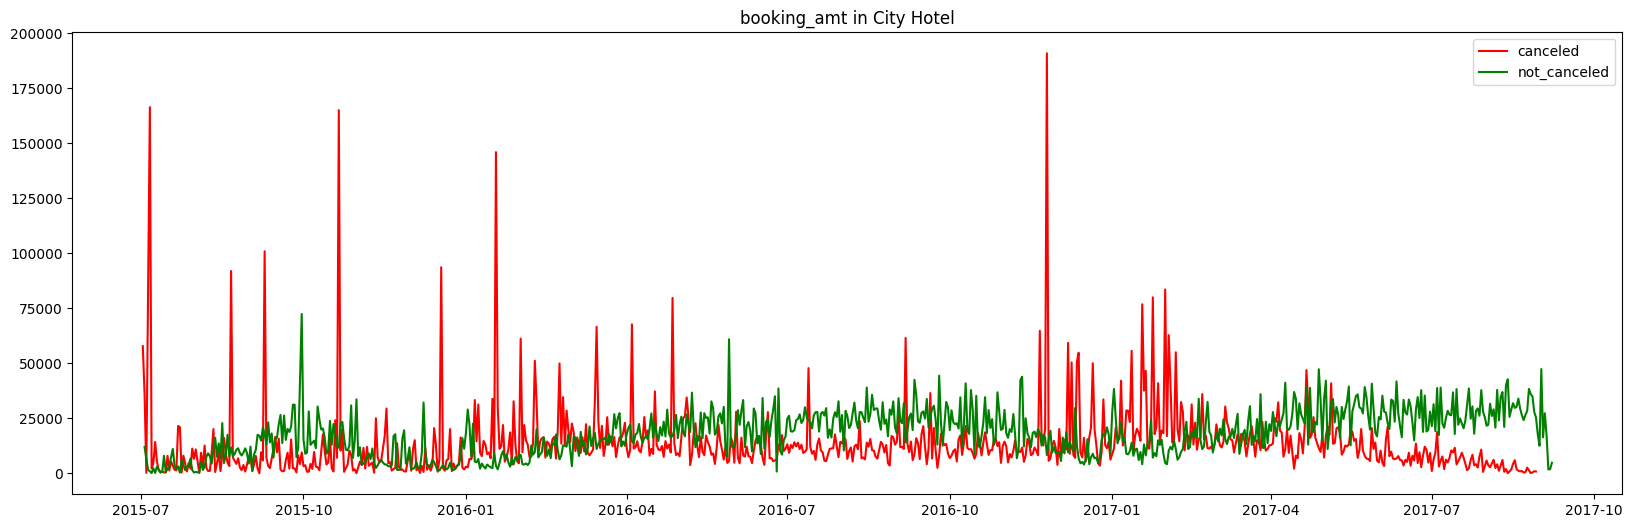

In [58]:
df_ch=df[df['hotel']=='City Hotel']
not_canceled_data= df_ch[df_ch['is_canceled']==0]
canceled_data=df_ch[df_ch['is_canceled']==1]

canceled_df_adr= canceled_data.groupby('reservation_status_date')[['booking_amt']].sum()
canceled_df_adr.reset_index(inplace=True)
canceled_df_adr.sort_values('reservation_status_date',inplace=True)

not_canceled_df_adr= not_canceled_data.groupby('reservation_status_date')[['booking_amt']].sum()
not_canceled_df_adr.reset_index(inplace=True)
not_canceled_df_adr.sort_values('reservation_status_date',inplace=True)

canceled_df_adr=canceled_df_adr[(canceled_df_adr['reservation_status_date'])>'2015-07']
not_canceled_df_adr=not_canceled_df_adr[(not_canceled_df_adr['reservation_status_date'])>'2015-07']

plt.figure(figsize=(20,6))
plt.title('booking_amt in City Hotel')
plt.plot(canceled_df_adr['reservation_status_date'], canceled_df_adr['booking_amt'], label='canceled', color='red')
plt.plot(not_canceled_df_adr['reservation_status_date'], not_canceled_df_adr['booking_amt'], label='not_canceled', color='green')

plt.legend()
plt.show()

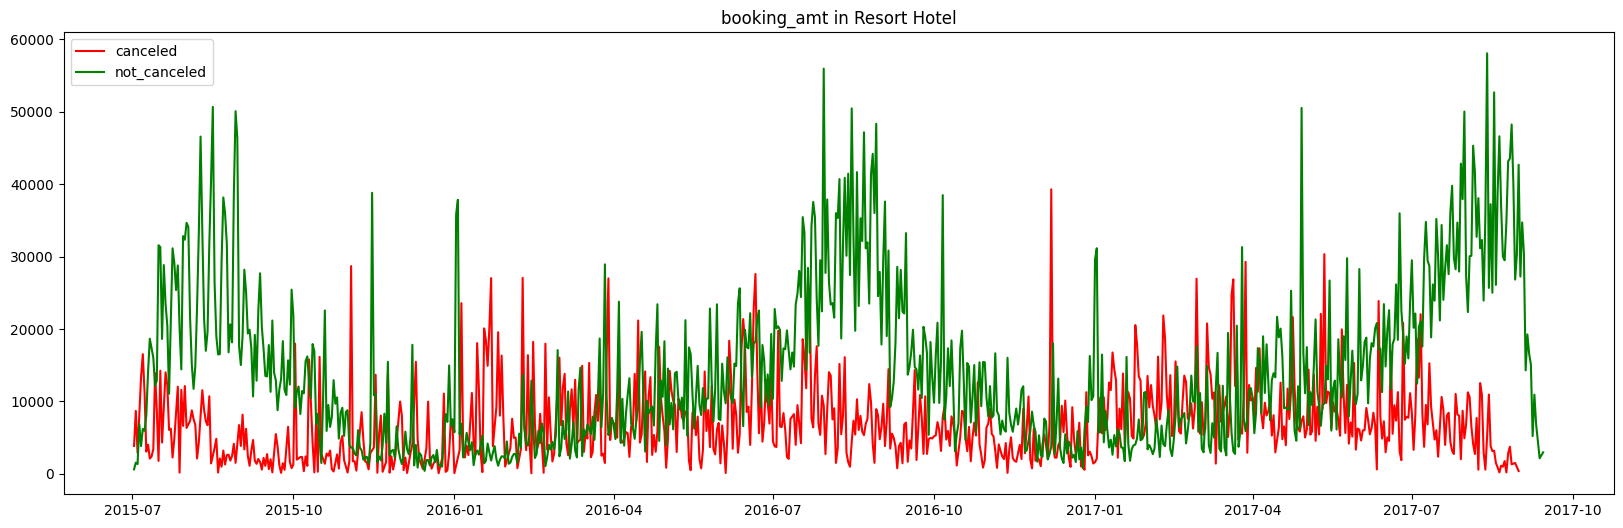

In [59]:
df_ch=df[df['hotel']=='Resort Hotel']
not_canceled_data= df_ch[df_ch['is_canceled']==0]
canceled_data=df_ch[df_ch['is_canceled']==1]

canceled_df_adr= canceled_data.groupby('reservation_status_date')[['booking_amt']].sum()
canceled_df_adr.reset_index(inplace=True)
canceled_df_adr.sort_values('reservation_status_date',inplace=True)

not_canceled_df_adr= not_canceled_data.groupby('reservation_status_date')[['booking_amt']].sum()
not_canceled_df_adr.reset_index(inplace=True)
not_canceled_df_adr.sort_values('reservation_status_date',inplace=True)

canceled_df_adr=canceled_df_adr[(canceled_df_adr['reservation_status_date'])>'2015-07']
not_canceled_df_adr=not_canceled_df_adr[(not_canceled_df_adr['reservation_status_date'])>'2015-07']

plt.figure(figsize=(20,6))
plt.title('booking_amt in Resort Hotel')
plt.plot(canceled_df_adr['reservation_status_date'], canceled_df_adr['booking_amt'], label='canceled', color='red')
plt.plot(not_canceled_df_adr['reservation_status_date'], not_canceled_df_adr['booking_amt'], label='not_canceled', color='green')

plt.legend()
plt.show()

the cancellation amount is range bound in both the hotels all over the seasons. In resort hotel, the booking amount even goes 5x of the muted times (i.e., dec-feb).

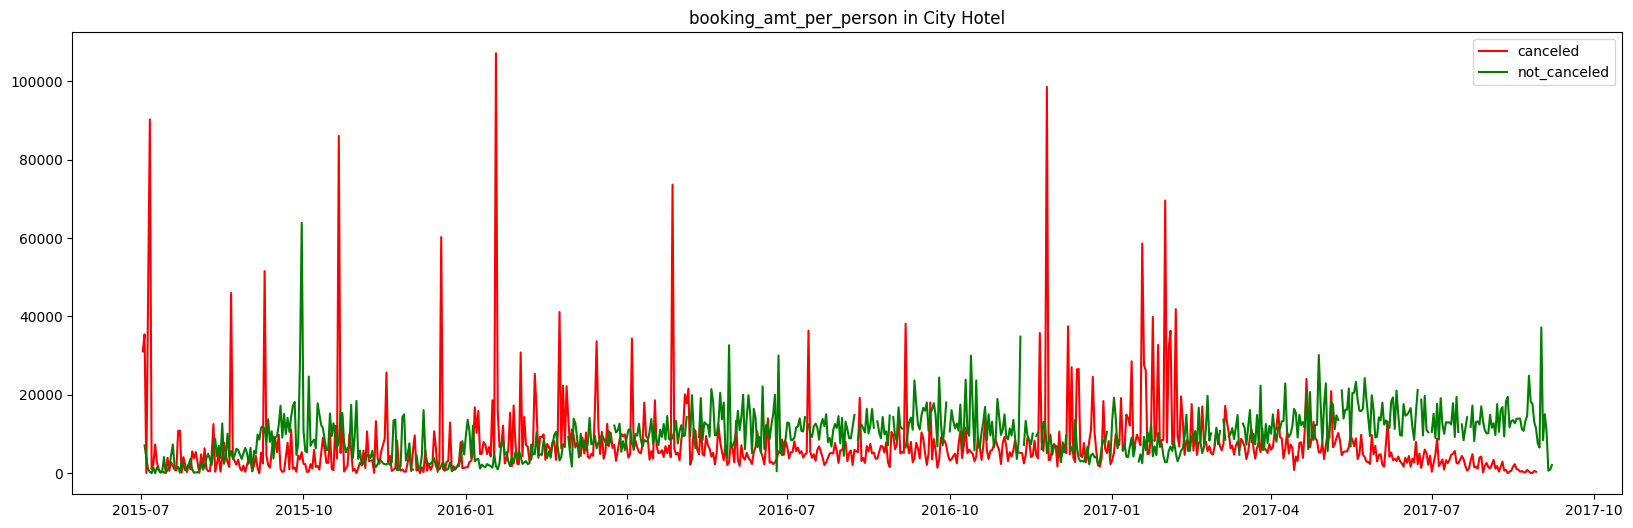

In [60]:
df_ch=df[df['hotel']=='City Hotel']
not_canceled_data= df_ch[df_ch['is_canceled']==0]
canceled_data=df_ch[df_ch['is_canceled']==1]

canceled_df_adr= canceled_data.groupby('reservation_status_date')[['booking_amt_per_person']].sum()
canceled_df_adr.reset_index(inplace=True)
canceled_df_adr.sort_values('reservation_status_date',inplace=True)

not_canceled_df_adr= not_canceled_data.groupby('reservation_status_date')[['booking_amt_per_person']].sum()
not_canceled_df_adr.reset_index(inplace=True)
not_canceled_df_adr.sort_values('reservation_status_date',inplace=True)

canceled_df_adr=canceled_df_adr[(canceled_df_adr['reservation_status_date'])>'2015-07']
not_canceled_df_adr=not_canceled_df_adr[(not_canceled_df_adr['reservation_status_date'])>'2015-07']

plt.figure(figsize=(20,6))
plt.title('booking_amt_per_person in City Hotel')
plt.plot(canceled_df_adr['reservation_status_date'], canceled_df_adr['booking_amt_per_person'], label='canceled', color='red')
plt.plot(not_canceled_df_adr['reservation_status_date'], not_canceled_df_adr['booking_amt_per_person'], label='not_canceled', color='green')

plt.legend()
plt.show()

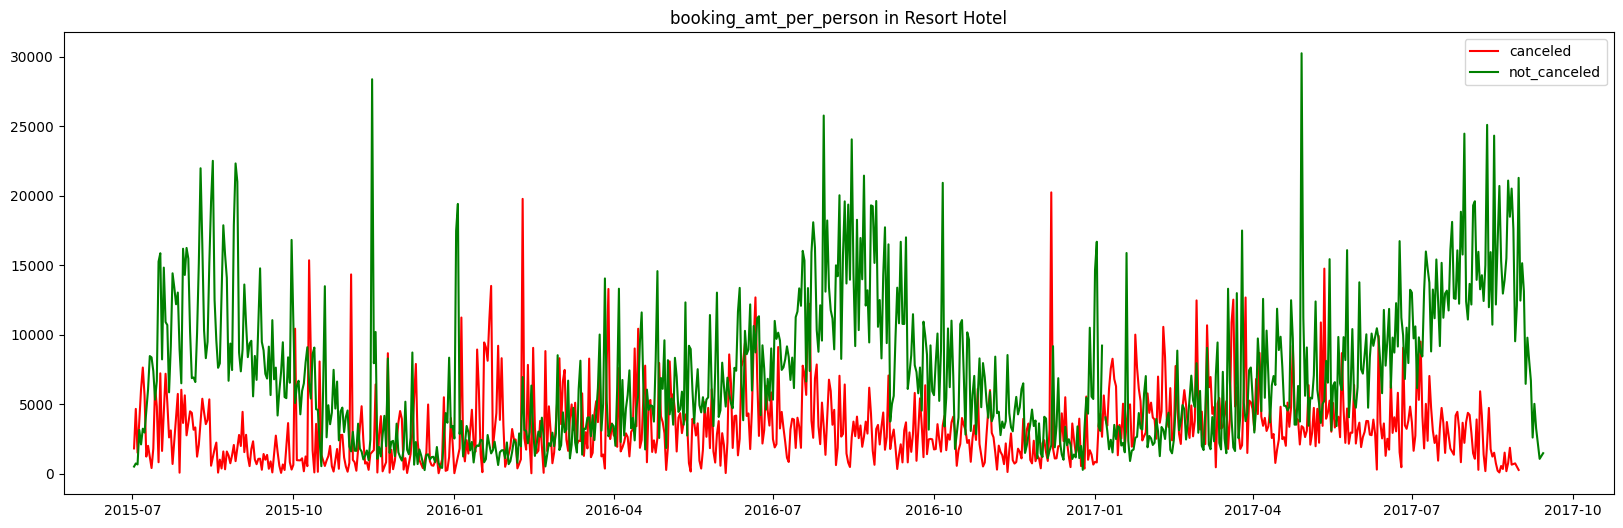

In [61]:
df_ch=df[df['hotel']=='Resort Hotel']
not_canceled_data= df_ch[df_ch['is_canceled']==0]
canceled_data=df_ch[df_ch['is_canceled']==1]

canceled_df_adr= canceled_data.groupby('reservation_status_date')[['booking_amt_per_person']].sum()
canceled_df_adr.reset_index(inplace=True)
canceled_df_adr.sort_values('reservation_status_date',inplace=True)

not_canceled_df_adr= not_canceled_data.groupby('reservation_status_date')[['booking_amt_per_person']].sum()
not_canceled_df_adr.reset_index(inplace=True)
not_canceled_df_adr.sort_values('reservation_status_date',inplace=True)

canceled_df_adr=canceled_df_adr[(canceled_df_adr['reservation_status_date'])>'2015-07']
not_canceled_df_adr=not_canceled_df_adr[(not_canceled_df_adr['reservation_status_date'])>'2015-07']

plt.figure(figsize=(20,6))
plt.title('booking_amt_per_person in Resort Hotel')
plt.plot(canceled_df_adr['reservation_status_date'], canceled_df_adr['booking_amt_per_person'], label='canceled', color='red')
plt.plot(not_canceled_df_adr['reservation_status_date'], not_canceled_df_adr['booking_amt_per_person'], label='not_canceled', color='green')

plt.legend()
plt.show()

Booking amount per person follows similar trend and seasonal variations as in the total booking amount variations in both the hotels. It shows that the booking amount per individual also increases with the increase in travellers at the peak times.
interestingly, the cancelled bookings in the Aug-Sep months has less booking amount per person in Resort Hotel. It implies that hotels booked for smaller durations are more likely to get cancelled.

In [62]:
top10_countries = (df['country'].value_counts(normalize=True)*100).to_frame().head(10)
top10_countries.reset_index(inplace=True)
top10_countries.columns=['location','loc_count_share']
countries_list=top10_countries['location'].unique().tolist()

In [63]:
def loc_tag(df):
    if df['country'] in countries_list:
        return df['country']
    else:
        return 'others'

df['country_tag']=df.apply(loc_tag, axis=1)
df.head(10)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,reservation_status_month,arrival_date_month_num,booking_amt,booking_amt_per_person,country_tag
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,7,7,75.0,75.00,GBR
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,7,7,75.0,75.00,GBR
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,98.0,0,1,Check-Out,2015-07-03,7,7,196.0,98.00,GBR
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,98.0,0,1,Check-Out,2015-07-03,7,7,196.0,98.00,GBR
6,Resort Hotel,0,0,2015,July,27,1,0,2,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,0,Transient,107.0,0,0,Check-Out,2015-07-03,7,7,214.0,107.00,PRT
7,Resort Hotel,0,9,2015,July,27,1,0,2,2,0.0,0,FB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,0,Transient,103.0,0,1,Check-Out,2015-07-03,7,7,206.0,103.00,PRT
8,Resort Hotel,1,85,2015,July,27,1,0,3,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,82.0,0,1,Canceled,2015-05-06,5,7,246.0,123.00,PRT
9,Resort Hotel,1,75,2015,July,27,1,0,3,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,0,Transient,105.5,0,0,Canceled,2015-04-22,4,7,316.5,158.25,PRT
10,Resort Hotel,1,23,2015,July,27,1,0,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,0,Transient,123.0,0,0,Canceled,2015-06-23,6,7,492.0,246.00,PRT
11,Resort Hotel,0,35,2015,July,27,1,0,4,2,0.0,0,HB,PRT,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,0,Transient,145.0,0,0,Check-Out,2015-07-05,7,7,580.0,290.00,PRT


In [64]:
df['country_tag'].value_counts(normalize=True)*100

PRT       40.057566
others    15.734346
GBR       10.266454
FRA        8.822202
ESP        7.228926
DEU        6.170432
ITA        3.192513
IRL        2.868919
BEL        1.987550
BRA        1.882808
NLD        1.788284
Name: country_tag, dtype: float64

In [65]:
df.drop(['reservation_status', 'reservation_status_date','country'], axis=1, inplace= True) #'agent','company',

In [66]:
df.drop(['previous_bookings_not_canceled','booking_changes','reservation_status_month','booking_amt', 'booking_amt_per_person','arrival_date_month_num'], axis = 1, inplace=True)

In [67]:
df.shape

(117431, 26)

We will run different ML algorithms so as to predict cancellations so as to reduce cost/maximize profits and free up resources.

In [68]:
#splitting into dependent and target dataset
X = df.drop(['is_canceled'],axis=1).copy()
y = df['is_canceled'].copy()

In [69]:
X.shape, y.shape

((117431, 25), (117431,))

In [71]:
#let's do one hot encoding for the objects data type columns
OHE_X=pd.get_dummies(X, columns= X.columns[X.dtypes=='object'].to_list(),drop_first=True)

In [72]:
#train-test split of the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(OHE_X, y, random_state=1, stratify=y, test_size=0.2)

#Logistic Regression

In [73]:
clf = LogisticRegression()

# define grid
solvers = ['sag', 'lbfgs', 'liblinear', 'newton-cholesky', 'saga']
param_grid = dict(solver=solvers,C=np.arange(0.01,1,0.01))

# define random search
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, n_iter = 20, n_jobs=-1, scoring='accuracy',random_state=1)
# execute the grid search
random_search_result = random_search.fit(X_train, y_train)

# report the best configuration
print("Best: %f using %s" % (random_search_result.best_score_, random_search_result.best_params_))
# report all configurations
means = random_search_result.cv_results_['mean_test_score']
stds = random_search_result.cv_results_['std_test_score']
params = random_search_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.809333 using {'solver': 'newton-cholesky', 'C': 0.43}
0.786255 (0.007334) with: {'solver': 'lbfgs', 'C': 0.8300000000000001}
0.807949 (0.002667) with: {'solver': 'liblinear', 'C': 0.22}
0.695286 (0.030857) with: {'solver': 'sag', 'C': 0.34}
0.807364 (0.002258) with: {'solver': 'liblinear', 'C': 0.4}
0.695254 (0.030739) with: {'solver': 'sag', 'C': 0.65}
0.683045 (0.019595) with: {'solver': 'saga', 'C': 0.33}
0.682843 (0.019299) with: {'solver': 'saga', 'C': 0.93}
0.809248 (0.002351) with: {'solver': 'newton-cholesky', 'C': 0.35000000000000003}
0.683024 (0.019606) with: {'solver': 'saga', 'C': 0.06999999999999999}
0.786681 (0.012408) with: {'solver': 'lbfgs', 'C': 0.66}
0.806959 (0.001871) with: {'solver': 'liblinear', 'C': 0.14}
0.695340 (0.030910) with: {'solver': 'sag', 'C': 0.18000000000000002}
0.695350 (0.030960) with: {'solver': 'sag', 'C': 0.53}
0.695372 (0.030893) with: {'solver': 'sag', 'C': 0.47000000000000003}
0.695265 (0.030815) with: {'solver': 'sag', 'C': 0.9}
0.80

let's try with the best accuracy parameters.

In [74]:
clf = LogisticRegression(solver='newton-cholesky', C = 0.43)

clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

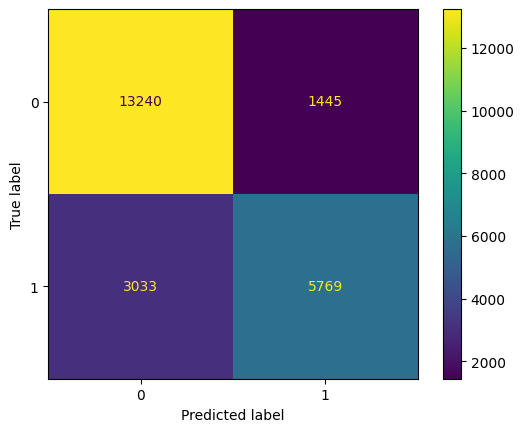

In [75]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [77]:
# Predict class labels on training data
pred_labels_tr = clf.predict(X_train)
# Predict class labels on a test data
pred_labels_te = clf.predict(X_test)

# Basic info about the model
print('*************** Logistic Regression Summary ***************')
#print('No. of classes: ', clf.n_classes_)
print('Classes: ', clf.classes_)
print('No. of features: ', clf.n_features_in_)
#print('No. of Estimators: ', clf.n_estimators)
print('--------------------------------------------------------')
print("")

print('*************** Evaluation on Test Data ***************')
score_te = clf.score(X_test, y_test)
print('Accuracy Score: ', score_te)
# Look at classification report to evaluate the model
print(classification_report(y_test, pred_labels_te))
print('--------------------------------------------------------')
print("")

print('*************** Evaluation on Training Data ***************')
score_tr = clf.score(X_train, y_train)
print('Accuracy Score: ', score_tr)
# Look at classification report to evaluate the model
print(classification_report(y_train, pred_labels_tr))
print('--------------------------------------------------------')

*************** Logistic Regression Summary ***************
Classes:  [0 1]
No. of features:  75
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Accuracy Score:  0.8093413377613148
              precision    recall  f1-score   support

           0       0.81      0.90      0.86     14685
           1       0.80      0.66      0.72      8802

    accuracy                           0.81     23487
   macro avg       0.81      0.78      0.79     23487
weighted avg       0.81      0.81      0.80     23487

--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.8096632036106617
              precision    recall  f1-score   support

           0       0.81      0.90      0.86     58735
           1       0.80      0.65      0.72     35209

    accuracy                           0.81     93944
   macro avg       0.81      0.78      0.79     93944


we will now change threshold value so as to get the idea on how the model is behaving in predicting the positives.

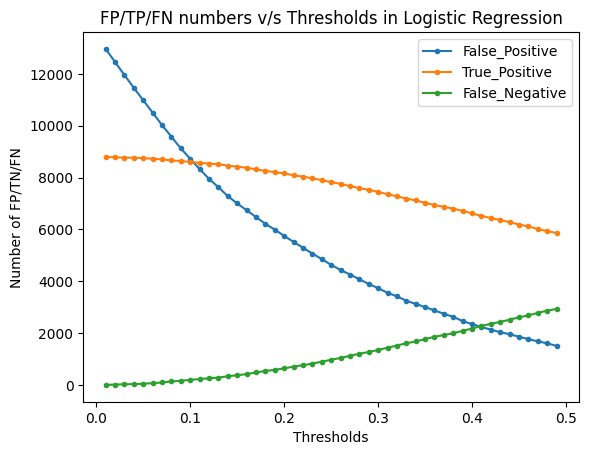

In [78]:
threshold = [i for i in np.arange(0.01, 0.5, 0.01)]
fp=[]
tp=[]
fn=[]
for thr in threshold:
    y_pred = (clf.predict_proba(X_test)[:, 1] >= thr).astype('float')
    fp.append(confusion_matrix(y_test, y_pred)[0,1])
    tp.append(confusion_matrix(y_test, y_pred)[1,1])
    fn.append(confusion_matrix(y_test, y_pred)[1,0])

plt.plot(threshold, fp, marker='.', label='False_Positive')
plt.plot(threshold, tp, marker='.', label='True_Positive')
plt.plot(threshold, fn, marker='.', label='False_Negative')
plt.xlabel('Thresholds')
plt.ylabel('Number of FP/TN/FN')
plt.title('FP/TP/FN numbers v/s Thresholds in Logistic Regression')
plt.legend()
plt.show()

lets assign relative benefit to tp, fn, fp as +10:-6:-4

It means in the cases of right predictions we get benefit of 10 unit as it is allowing us to free up resources. In cases of false negative prediction we are loosing resources of cost 6 units. In cases of false positive prediction we are providing free add ons so as to attract the customer and incurring cost of 2 units.

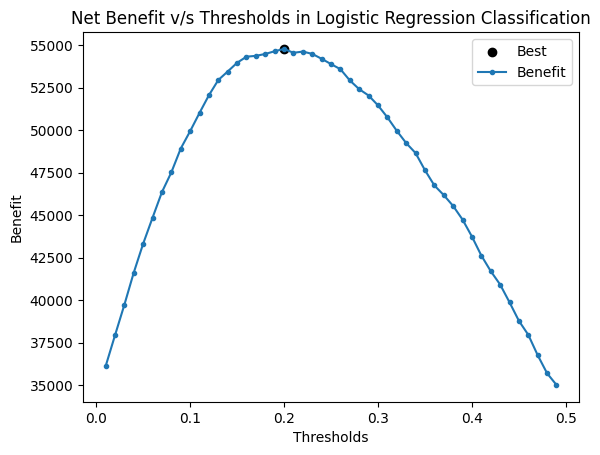

best result at 0.2


In [79]:
net_benefit =[]
for i in range(0,len(fp)):
    net_benefit.append(10*tp[i] -6*fn[i] -4*fp[i])

ix = np.argmax(net_benefit)
plt.scatter(threshold[ix], net_benefit[ix], marker='o', color='black', label='Best')
plt.plot(threshold, net_benefit, marker='.', label='Benefit')
plt.xlabel('Thresholds')
plt.ylabel('Benefit')
plt.title('Net Benefit v/s Thresholds in Logistic Regression Classification')
plt.legend()
plt.show()
print(f'best result at {threshold[ix]}')

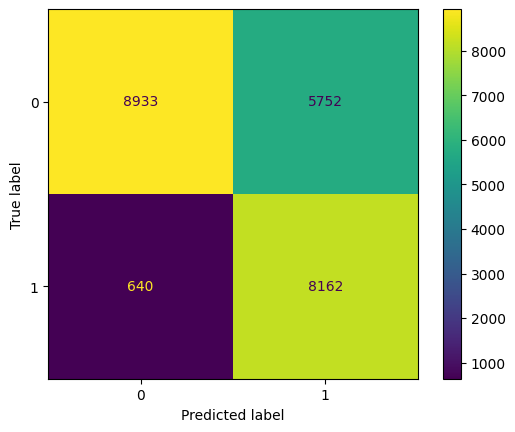

In [80]:
threshold = 0.2
y_pred = (clf.predict_proba(X_test)[:, 1] >= threshold).astype('float')
confusion_matrix(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

here we can catch many more true positives as compared to prervious model with default 0.5 as probability threshold.

#Random Forest Classification

In [81]:
clf = RandomForestClassifier()

params = {'max_features' : ['sqrt', 'log2'],
              'criterion' : ['gini', 'entropy', 'log_loss'],
              'bootstrap' : [True,False]}

random_search = RandomizedSearchCV(clf,param_distributions=params,n_iter=5,
                                   random_state = 1,
                                 n_jobs=-1,cv=5,verbose=3,
                                 return_train_score=True,
                                 error_score='raise')

#fitting random_search to the traning set
random_search.fit(X_train, y_train)

random_search.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'max_features': 'sqrt', 'criterion': 'entropy', 'bootstrap': True}

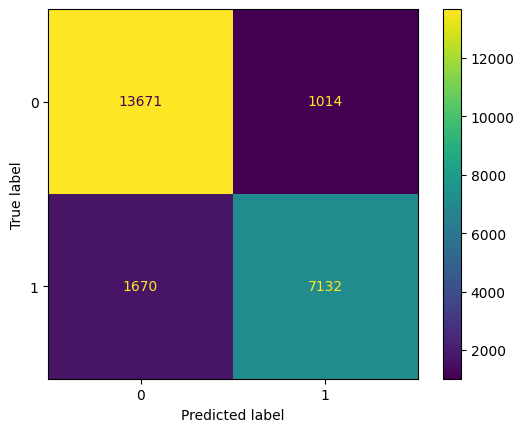

In [82]:
clf = random_search.best_estimator_

clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

In [83]:
# Predict class labels on training data
pred_labels_tr = clf.predict(X_train)
# Predict class labels on a test data
pred_labels_te = clf.predict(X_test)

# Basic info about the model
print('*************** Random Forest Classification Summary ***************')
#print('No. of classes: ', clf.n_classes_)
print('Classes: ', clf.classes_)
print('No. of features: ', clf.n_features_in_)
#print('No. of Estimators: ', clf.n_estimators)
print('--------------------------------------------------------')
print("")

print('*************** Evaluation on Test Data ***************')
score_te = clf.score(X_test, y_test)
print('Accuracy Score: ', score_te)
# Look at classification report to evaluate the model
print(classification_report(y_test, pred_labels_te))
print('--------------------------------------------------------')
print("")

print('*************** Evaluation on Training Data ***************')
score_tr = clf.score(X_train, y_train)
print('Accuracy Score: ', score_tr)
# Look at classification report to evaluate the model
print(classification_report(y_train, pred_labels_tr))
print('--------------------------------------------------------')

*************** Random Forest Classification Summary ***************
Classes:  [0 1]
No. of features:  75
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Accuracy Score:  0.8857240175416188
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     14685
           1       0.88      0.81      0.84      8802

    accuracy                           0.89     23487
   macro avg       0.88      0.87      0.88     23487
weighted avg       0.89      0.89      0.88     23487

--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.9959869709614239
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58735
           1       1.00      0.99      0.99     35209

    accuracy                           1.00     93944
   macro avg       1.00      1.00      1.00  

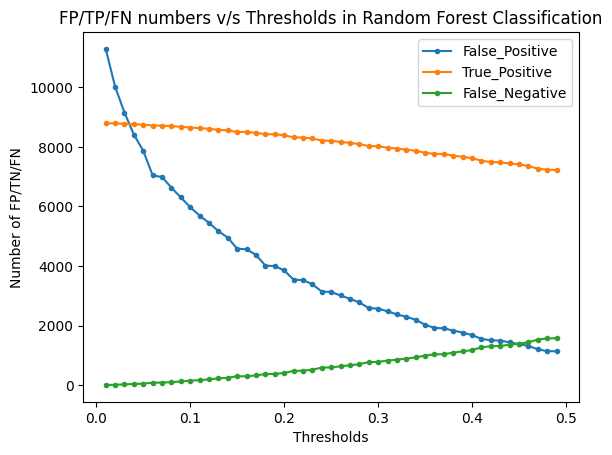

In [84]:
threshold = [i for i in np.arange(0.01, 0.5, 0.01)]
fp=[]
tp=[]
fn=[]
for thr in threshold:
    y_pred = (clf.predict_proba(X_test)[:, 1] >= thr).astype('float')
    fp.append(confusion_matrix(y_test, y_pred)[0,1])
    tp.append(confusion_matrix(y_test, y_pred)[1,1])
    fn.append(confusion_matrix(y_test, y_pred)[1,0])

plt.plot(threshold, fp, marker='.', label='False_Positive')
plt.plot(threshold, tp, marker='.', label='True_Positive')
plt.plot(threshold, fn, marker='.', label='False_Negative')
plt.xlabel('Thresholds')
plt.ylabel('Number of FP/TN/FN')
plt.title('FP/TP/FN numbers v/s Thresholds in Random Forest Classification')
plt.legend()
plt.show()

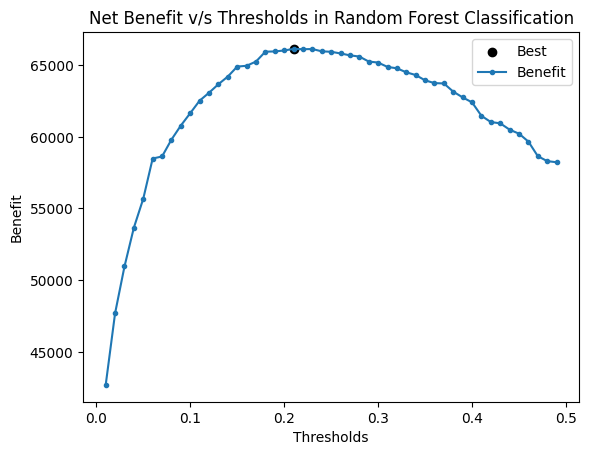

best result at 0.21000000000000002


In [85]:
net_benefit =[]
for i in range(0,len(fp)):
    net_benefit.append(10*tp[i] -6*fn[i] -4*fp[i])

ix = np.argmax(net_benefit)
plt.scatter(threshold[ix], net_benefit[ix], marker='o', color='black', label='Best')
plt.plot(threshold, net_benefit, marker='.', label='Benefit')
plt.xlabel('Thresholds')
plt.ylabel('Benefit')
plt.title('Net Benefit v/s Thresholds in Random Forest Classification')
plt.legend()
plt.show()
print(f'best result at {threshold[ix]}')

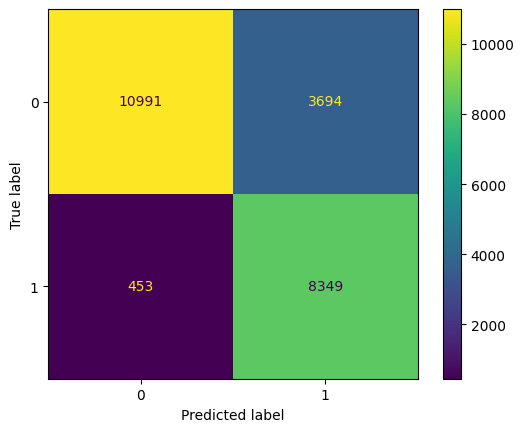

In [86]:
threshold = 0.21
y_pred = (clf.predict_proba(X_test)[:, 1] >= threshold).astype('float')
confusion_matrix(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

We are catching much more positives with Random Forest classifcation method than before with 0.5 probability. The benefit we get in Random Forest is more than the Lostic Regression.

#XGBoost Classification

In [87]:
clf=xgboost.XGBClassifier()
params={
 "learning_rate"    : [i for i in np.arange(0.2,0.8,0.1)] ,
 "max_depth"        : [ i for i in range(2,6)],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
 "booster"          : ['gbtree', 'dart'],
 "eval_metric"      : ['rmse', 'rmsle','logloss', 'auc', 'aucpr']
}

random_search=RandomizedSearchCV(clf,param_distributions=params,n_iter=5,
                                 random_state = 1,
                                 n_jobs=-1,cv=5,verbose=3,
                                 return_train_score=True,
                                 error_score='raise')
random_search.fit(X_train,y_train)
pd.DataFrame(random_search.cv_results_).to_csv('param.csv')
clf = random_search.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [88]:
# #let's calculate accurarcy score on test set
# from sklearn.model_selection import cross_val_score
score=cross_val_score(clf , X_test, y_test, cv=10, error_score='raise')
score.mean()

0.8511507307107378

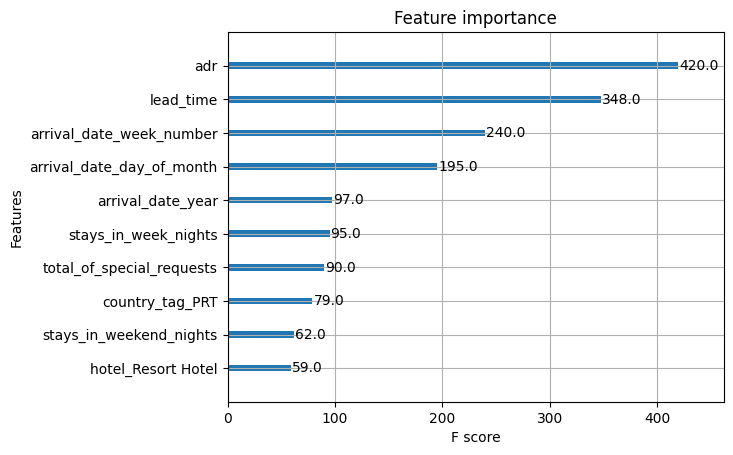

In [89]:
%matplotlib inline
from xgboost import XGBClassifier, plot_importance
#clf= random_search.best_estimator_
fit = clf.fit(X_train, y_train)
plot_importance(fit, max_num_features=10)
plt.show()

It shows the features which have more importance than others in terms of deciding a cancellation. adr, lead time have the highest importance in deciding the cancellation.

In [91]:
model= random_search.best_estimator_
model.fit(X_train, y_train)

# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

Permutation explainer: 23488it [7:15:22,  1.11s/it]


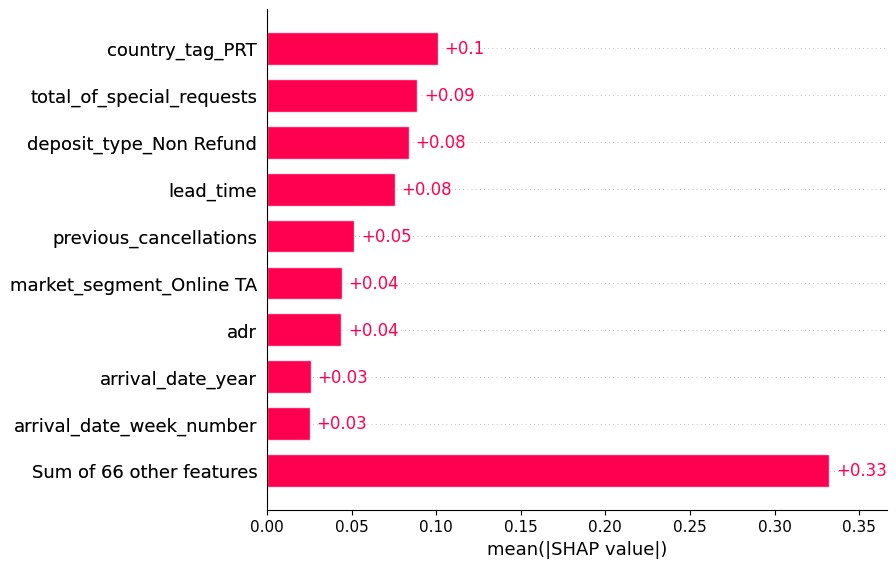

In [92]:
shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


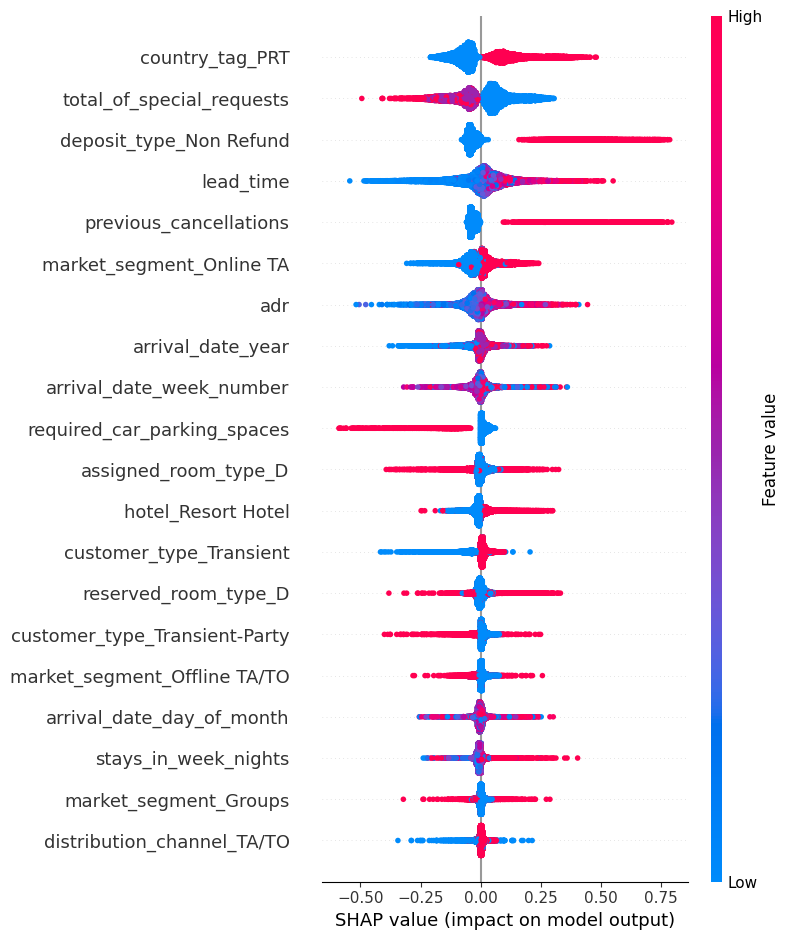

In [93]:
shap.summary_plot(shap_values)

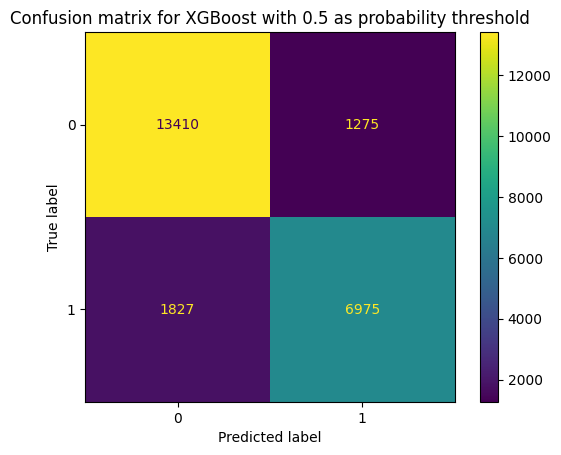

In [94]:
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.title('Confusion matrix for XGBoost with 0.5 as probability threshold')
plt.show()

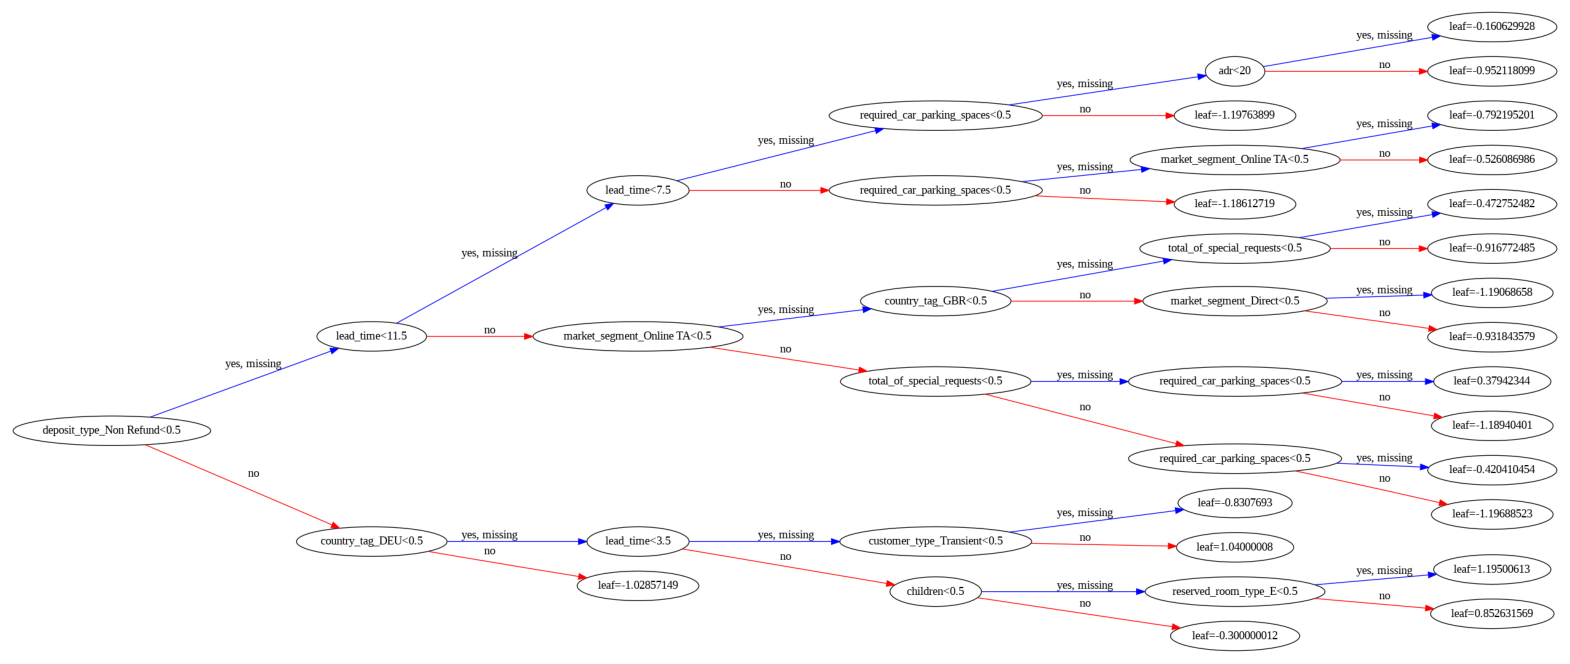

In [95]:
plot_tree(clf, rankdir='LR')
#plt.rcParams['figure.figsize']=[50, 30]
plt.gcf().set_size_inches(20, 10)
plt.savefig("HotelBooking_xgb.png")

In [96]:
# Predict class labels on training data
pred_labels_tr = clf.predict(X_train)
# Predict class labels on a test data
pred_labels_te = clf.predict(X_test)

# Basic info about the model
print('*************** Tree Summary in XGBoost ***************')
print('No. of classes: ', clf.n_classes_)
print('Classes: ', clf.classes_)
print('No. of features: ', clf.n_features_in_)
print('No. of Estimators: ', clf.n_estimators)
print('--------------------------------------------------------')
print("")

print('*************** Evaluation on Test Data ***************')
score_te = clf.score(X_test, y_test)
print('Accuracy Score: ', score_te)
# Look at classification report to evaluate the model
print(classification_report(y_test, pred_labels_te))
print('--------------------------------------------------------')
print("")

print('*************** Evaluation on Training Data ***************')
score_tr = clf.score(X_train, y_train)
print('Accuracy Score: ', score_tr)
# Look at classification report to evaluate the model
print(classification_report(y_train, pred_labels_tr))
print('--------------------------------------------------------')

*************** Tree Summary in XGBoost ***************
No. of classes:  2
Classes:  [0 1]
No. of features:  75
No. of Estimators:  100
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Accuracy Score:  0.8679269383062971
              precision    recall  f1-score   support

           0       0.88      0.91      0.90     14685
           1       0.85      0.79      0.82      8802

    accuracy                           0.87     23487
   macro avg       0.86      0.85      0.86     23487
weighted avg       0.87      0.87      0.87     23487

--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.8893063952993273
              precision    recall  f1-score   support

           0       0.90      0.93      0.91     58735
           1       0.87      0.82      0.85     35209

    accuracy                           0.89     93944
   macro avg   

No Skill: ROC AUC=0.500
XGB: ROC AUC=0.943
Best Threshold=0.385311, G-Mean=0.860


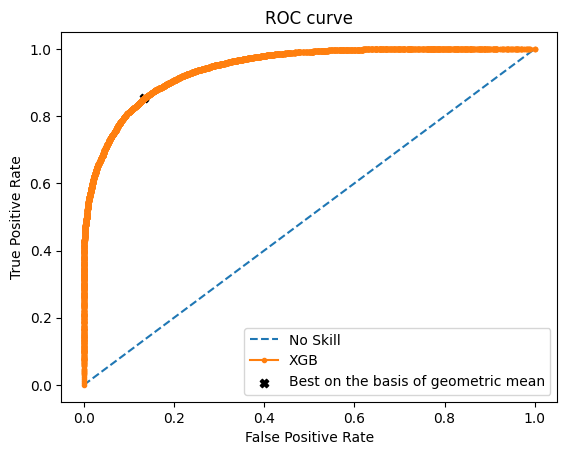

In [97]:
# predict probabilities
clf_probs = clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
clf_probs = clf_probs[:, 1]

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# calculate scores
clf_auc = roc_auc_score(y_test, clf_probs)
ns_auc = roc_auc_score(y_test, ns_probs)

# predict probabilities
yhat = clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
fnr = 1- tpr

gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGB: ROC AUC=%.3f' % (clf_auc))
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='XGB')
plt.scatter(fpr[ix], tpr[ix], marker='X', color='black', label='Best on the basis of geometric mean')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
# show the plot
plt.show()

XGB: f1=0.818 auc=0.920
Best Threshold=0.385311, F-Score=0.822


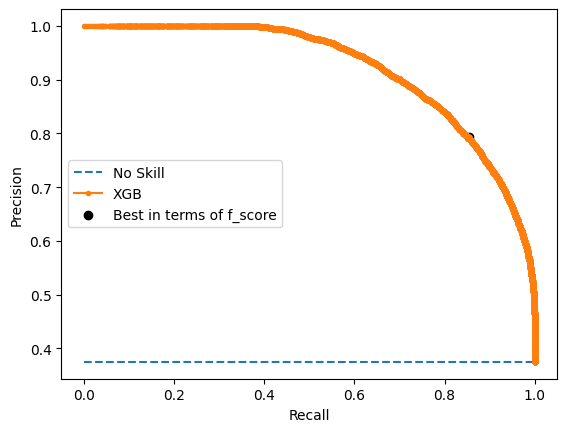

In [98]:
# predict probabilities
clf_probs = clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
clf_probs = clf_probs[:, 1]
# predict class values
yhat = clf.predict(X_test)


clf_precision, clf_recall, thresholds = precision_recall_curve(y_test, clf_probs) # thrershold change
clf_f1, clf_auc = f1_score(y_test, yhat), auc(clf_recall, clf_precision)

# calculate roc curves
precision, recall, thresholds = precision_recall_curve(y_test, clf_probs)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)

# summarize scores
print('XGB: f1=%.3f auc=%.3f' % (clf_f1, clf_auc))
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(clf_recall, clf_precision, marker='.', label='XGB')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best in terms of f_score')

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

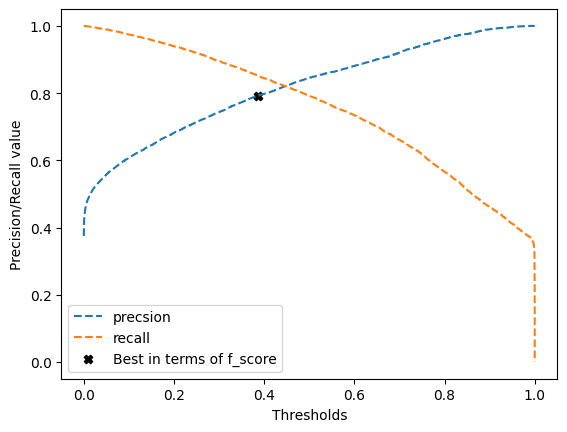

In [99]:
plt.plot(thresholds, precision[1:,], linestyle='--',label='precsion')
plt.plot(thresholds, recall[1:,], linestyle='--',label='recall')
plt.scatter(thresholds[ix], precision[ix], marker='X', color='black', label='Best in terms of f_score')
plt.xlabel('Thresholds')
plt.ylabel('Precision/Recall value')
plt.legend()
plt.show()

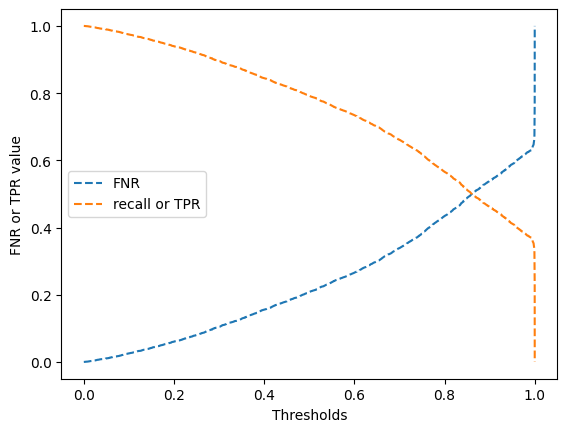

In [100]:
fnr = 1 - recall
plt.plot(thresholds, fnr[1:,], linestyle='--',label='FNR')
plt.plot(thresholds, recall[1:,], linestyle='--',label='recall or TPR')
#pyplot.scatter(thresholds[ix], precision[ix], marker='X', color='black', label='Best')
plt.xlabel('Thresholds')
plt.ylabel('FNR or TPR value')
plt.legend()
plt.show()

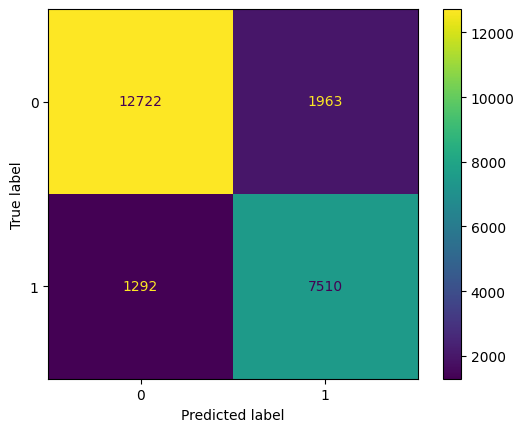

In [101]:
threshold = 0.385311 #n terms of best f_score
y_pred = (clf.predict_proba(X_test)[:, 1] >= threshold).astype('float')
confusion_matrix(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

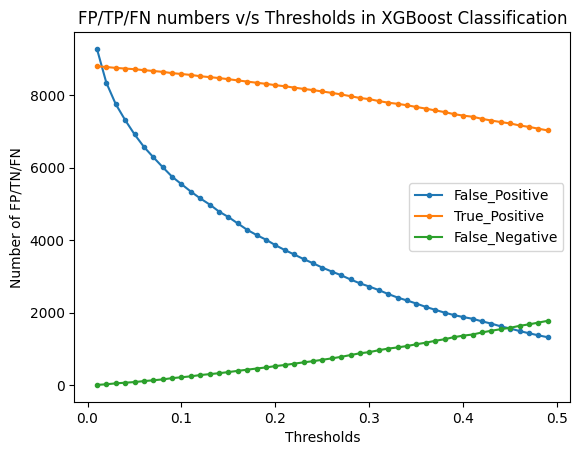

In [102]:
threshold = [i for i in np.arange(0.01, 0.5, 0.01)]
fp=[]
tp=[]
fn=[]
for thr in threshold:
    y_pred = (clf.predict_proba(X_test)[:, 1] >= thr).astype('float')
    fp.append(confusion_matrix(y_test, y_pred)[0,1])
    tp.append(confusion_matrix(y_test, y_pred)[1,1])
    fn.append(confusion_matrix(y_test, y_pred)[1,0])

plt.plot(threshold, fp, marker='.', label='False_Positive')
plt.plot(threshold, tp, marker='.', label='True_Positive')
plt.plot(threshold, fn, marker='.', label='False_Negative')
plt.xlabel('Thresholds')
plt.ylabel('Number of FP/TN/FN')
plt.title('FP/TP/FN numbers v/s Thresholds in XGBoost Classification')
plt.legend()
plt.show()

Here, we are to determine the best threshold probability where we can get the maximum benefit as profit.

Let's assign relative benefit to tp, fn, fp as +10:-6:-4

It means in the cases of right predictions we get benefit of 10 unit as it is allowing us to free up resources. In cases of false negative prediction we are loosing resources of cost 6 units. In cases of false positive prediction we are providing free add ons so as to attract the customer and incurring cost of 2 units.

20


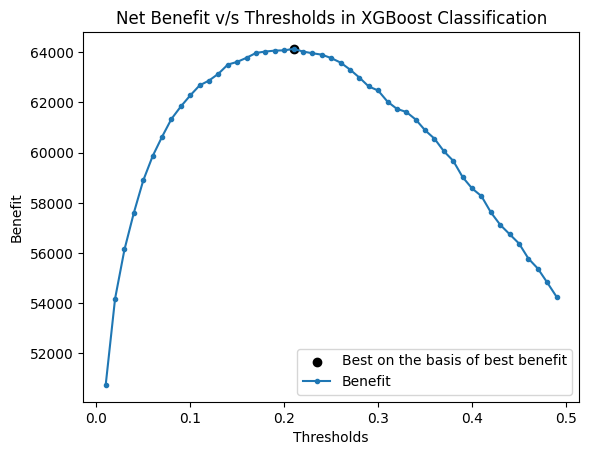

best result at threshold= 0.21000000000000002


In [104]:
net_benefit =[]
for i in range(0,len(fp)):
    net_benefit.append(10*tp[i] -6*fn[i] -4*fp[i])

ix = np.argmax(net_benefit)
print(ix)

plt.scatter(threshold[ix], net_benefit[ix], marker='o', color='black', label='Best on the basis of best benefit')
plt.plot(threshold, net_benefit, marker='.', label='Benefit')
plt.xlabel('Thresholds')
plt.ylabel('Benefit')
plt.title('Net Benefit v/s Thresholds in XGBoost Classification')
plt.legend()
plt.show()
print(f'best result at threshold= {threshold[ix]}')

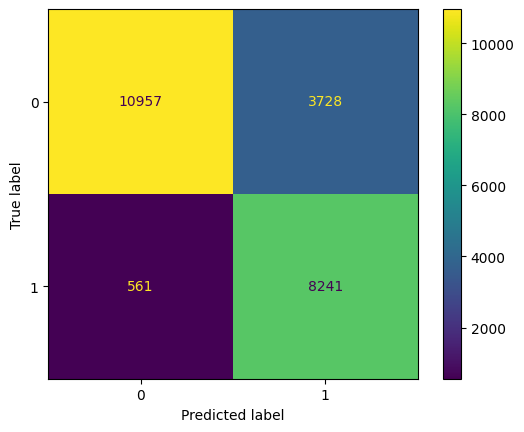

In [105]:
threshold = 0.21 #n terms of best benefit value
y_pred = (clf.predict_proba(X_test)[:, 1] >= threshold).astype('float')
confusion_matrix(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

##Conclusion

In terms of monetary benefiit we can see that Random Forest Classification gives better result than XGBoost and far better than Logistic Regression. Though we showed the behavior of the models at their best F-Scores the model selection and evaluation on the basis of monetary benefit makes more sense.